# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблем, предоставляемым библиотекой CatBoost.

In [28]:
from sklearn.model_selection import train_test_split as tts
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from catboost import CatBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as dec_tree_class
from sklearn.model_selection import KFold
from sklearn import metrics

In [3]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    data = pd.read_csv(path_to_csv)
    data['label'] = (data['label'] == 'M').astype(int)
    X = data.drop("label", axis=1)
    y = data.label
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    data = pd.read_csv(path_to_csv)
    X = data.drop("label", axis=1)
    y = data.label
    return X, y

def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train, X_test, y_train, y_test = tts(X, y, train_size = ratio)
    return X_train, y_train, X_test, y_test

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [82]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion=criterion
        self.max_depth=max_depth
        self.min_samples_leaf=min_samples_leaf
        self.max_features=max_features
        self.n_estimators=n_estimators

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        X['label'] = y
        self.clfs = []
        self.oob_err = 0
        for i in range(self.n_estimators):
            data = X.sample(n=len(X), replace=True)           
            
            X_sample = data.drop("label", axis=1)
            y_sample = data.label
            sample_i = np.unique(X_sample.index)
            sample_i = np.unique(X_sample.index)
            clf = dec_tree_class(criterion=self.criterion, max_depth=self.max_depth, max_features=self.max_features)
            clf = clf.fit(X_sample, y_sample)
            self.clfs.append(clf)
            
            #for out-of-bag
            sample_i = np.unique(data.index)
            if len(data) != len(sample_i):
                data_check = X.drop(sample_i)
                X_check = data_check.drop("label", axis=1)
                y_check = data_check.label
                predict = clf.predict(X_check)
                self.oob_err += np.sum(np.equal(predict, y_check)) / len(y_check)
        self.oob_err = 1 - self.oob_err / self.n_estimators
    
    def predict(self, X, proba = False):
        answers = np.array([0 for i in range(len(X))])
        for clf in self.clfs:
            answers+=clf.predict(X)
        if proba:
            return np.array([i/len(self.clfs) for i in answers])
        return np.array([1 if i > len(self.clfs)/2 else 0 for i in answers])

### Задание 2 (3 балла)
Оптимизируйте по AUC на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации Random Forest: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте ROC кривую (и выведите AUC и accuracy) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [124]:
def cross_validation(X, y, probable_depths, probable_n_estimators, n_splits = 5):
    kf = KFold(n_splits=n_splits, random_state=None, shuffle=True)
    aucs = []
    accuracies = []
    for depth in probable_depths:
        for n_estimator in probable_n_estimators:
            accuracy = 0
            auc = 0
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.loc[train_index], X.loc[test_index]
                y_train, y_test = y.loc[train_index], y.loc[test_index]
                clf = RandomForestClassifier(n_estimators=n_estimator, max_depth=depth)
                clf.fit(X_train, y_train)
                predictions = clf.predict(X_test)
                accuracy += metrics.accuracy_score(y_true = y_test, y_pred = predictions)
                auc += metrics.roc_auc_score(y_true = y_test, y_score = predictions)
            accuracy /= n_splits
            auc /= n_splits
            aucs.append(auc)
            accuracies.append(accuracy)
    max_auc = -1
    max_auc_i = []
    for i in range(len(aucs)):
        if aucs[i] > max_auc:
            max_auc = aucs[i]
            max_auc_i = []
        if aucs[i] >= max_auc:
            max_auc_i.append(i)
    print('Best AUC is %-8.4f' % (max_auc))
    print('parameters and accuracy:')
    for i in max_auc_i:
        print('max_depth = %-5d and n_estimators = %-5d with accuracy =  %-8.4f' %(probable_depths[(i) // len(probable_n_estimators)], probable_n_estimators[(i) % len(probable_n_estimators)], accuracies[i]))

In [141]:
def plot_roc_curve(X, y, n_estimators, max_depth):
    
    X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    clf.fit(X_train, y_train)
    p_pred = clf.predict(X_test, proba = True)
    positive_samples = sum(1 for y in y_test if y == 0)
    curves_tpr = []
    curves_fpr = []
    colors = ['red']
    tpr = []
    fpr = []
    predictions = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(1 if p > w else 0) for p in p_pred]
        if w == 0.5:
            predictions = y_pred
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    curves_tpr.append(tpr)
    curves_fpr.append(fpr)
    
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()
    cur_accuracy = metrics.accuracy_score(y_true = y_test, y_pred = predictions)
    cur_auc = metrics.roc_auc_score(y_true = y_test, y_score = predictions)
    print('accuracy = '+str(cur_accuracy))
    print('auc = '+str(cur_auc))

In [126]:
X, y = read_cancer_dataset("data/cancer.csv")
probable_depths = [2, 3, 5, 7, 10]
probable_n_estimators = [5, 10, 20, 30, 50, 100]
cross_validation(X, y, probable_depths, probable_n_estimators)

Best AUC is 0.9622  
parameters and accuracy:
max_depth = 10    and n_estimators = 50    with accuracy =  0.9684  


Получили результаты!!! Теперь на них еще раз прогоним и нарисуем ROC кривую

/home/toharhymes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


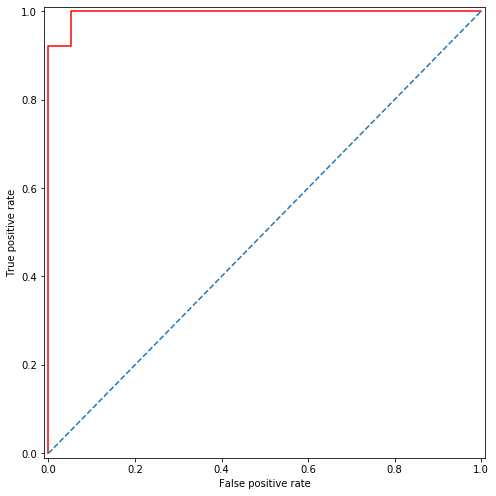

accuracy = 0.9298245614035088
auc = 0.9342105263157894


In [142]:
X, y = read_cancer_dataset("data/cancer.csv")
plot_roc_curve(X, y, n_estimators = 50, max_depth = 10)

### Задание 3 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [84]:
def feature_importance(rfc):
    err_oob = rfc.oob_err
    X = rfc.X
    y = rfc.y
    err_obj_array = []
    for feature in X:
        A = copy.deepcopy(X)
        random.shuffle(A[feature])
        rfc.fit(A, y)
        err_obj_array.append(rfc.oob_err)
    return err_obj_array

    

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [87]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)
X, y = synthetic_dataset(1000)


## Это не датафрейм, а нумпаевский массив, у меня возникала ошибка, сделаю датафрейм(костыльно, но уже некогда нормально)

for_data = {}
for_data.update({'c1':X[:,0]})
for_data.update({'c2':X[:,1]})
for_data.update({'c3':X[:,2]})
for_data.update({'c4':X[:,3]})
for_data.update({'c5':X[:,4]})
for_data.update({'c6':X[:,5]})
X = pd.DataFrame(data=for_data)



rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
# print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc))

Importance: [0.0, 0.0, 0.17897811444316247, 0.1750961851608449, 0.3423442137020012, 0.0, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

In [98]:
X, y = read_cancer_dataset("data/cancer.csv")
rfc = RandomForestClassifier(n_estimators = 70)
rfc.fit(X, y)
names = [i for i in range(31)]
print("Most important features: ", most_important_features(feature_importance(rfc), names=names, k=5))

/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: Setti

/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: Setti

Most important features:  [ 0 20  2 24 21]


In [102]:
X, y = read_cancer_dataset("data/spam.csv")
X
rfc = RandomForestClassifier(n_estimators = 70)
rfc.fit(X, y)
names = [i for i in range(59)]
print("Most important features: ", most_important_features(feature_importance(rfc), names=names, k=5))

/home/toharhymes/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: Setti

/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]
/home/toharhymes/anaconda3/lib/python3.7/random.py:278: Setti

Most important features:  [57 14 26 25 24]


### Задание 4 (1 балл)
В качестве аьтернативы попробуем CatBoost. 

Туториалы можно найти, например, [здесь](https://catboost.ai/docs/) и [здесь](https://github.com/catboost/tutorials/blob/master/python_tutorial.ipynb).

Также, как и реализованный ними RandomForest, примените его для наших датасетов.

In [148]:
X, y = read_cancer_dataset("data/cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)
cbc = CatBoostClassifier()
cbc.fit(X_train, y_train)
y_pred = cbc.predict(X_test)

Learning rate set to 0.00736
0:	learn: 0.6801164	total: 3.31ms	remaining: 3.31s
1:	learn: 0.6680074	total: 6.63ms	remaining: 3.31s
2:	learn: 0.6569310	total: 10.3ms	remaining: 3.41s
3:	learn: 0.6462190	total: 14ms	remaining: 3.48s
4:	learn: 0.6345424	total: 19.9ms	remaining: 3.95s
5:	learn: 0.6252142	total: 30.2ms	remaining: 5s
6:	learn: 0.6131858	total: 39.7ms	remaining: 5.63s
7:	learn: 0.6041401	total: 44.7ms	remaining: 5.54s
8:	learn: 0.5934701	total: 50.3ms	remaining: 5.54s
9:	learn: 0.5841790	total: 56.9ms	remaining: 5.63s
10:	learn: 0.5750127	total: 61.5ms	remaining: 5.53s
11:	learn: 0.5659999	total: 64.9ms	remaining: 5.34s
12:	learn: 0.5565875	total: 67.8ms	remaining: 5.15s
13:	learn: 0.5473856	total: 70.8ms	remaining: 4.98s
14:	learn: 0.5384316	total: 73.6ms	remaining: 4.83s
15:	learn: 0.5302641	total: 76.7ms	remaining: 4.72s
16:	learn: 0.5212206	total: 79.7ms	remaining: 4.61s
17:	learn: 0.5132543	total: 82.6ms	remaining: 4.51s
18:	learn: 0.5051934	total: 85.6ms	remaining: 4.42

163:	learn: 0.1120407	total: 578ms	remaining: 2.95s
164:	learn: 0.1112987	total: 582ms	remaining: 2.95s
165:	learn: 0.1105714	total: 585ms	remaining: 2.94s
166:	learn: 0.1098514	total: 588ms	remaining: 2.93s
167:	learn: 0.1091522	total: 591ms	remaining: 2.93s
168:	learn: 0.1085705	total: 594ms	remaining: 2.92s
169:	learn: 0.1080927	total: 597ms	remaining: 2.91s
170:	learn: 0.1074324	total: 600ms	remaining: 2.91s
171:	learn: 0.1068201	total: 606ms	remaining: 2.92s
172:	learn: 0.1061540	total: 611ms	remaining: 2.92s
173:	learn: 0.1056673	total: 614ms	remaining: 2.91s
174:	learn: 0.1049594	total: 616ms	remaining: 2.9s
175:	learn: 0.1042329	total: 619ms	remaining: 2.9s
176:	learn: 0.1035944	total: 624ms	remaining: 2.9s
177:	learn: 0.1029335	total: 630ms	remaining: 2.91s
178:	learn: 0.1023423	total: 634ms	remaining: 2.91s
179:	learn: 0.1016698	total: 638ms	remaining: 2.9s
180:	learn: 0.1011710	total: 640ms	remaining: 2.9s
181:	learn: 0.1004998	total: 644ms	remaining: 2.89s
182:	learn: 0.099

354:	learn: 0.0460428	total: 1.17s	remaining: 2.12s
355:	learn: 0.0458583	total: 1.17s	remaining: 2.12s
356:	learn: 0.0457059	total: 1.17s	remaining: 2.11s
357:	learn: 0.0456414	total: 1.18s	remaining: 2.11s
358:	learn: 0.0454566	total: 1.18s	remaining: 2.11s
359:	learn: 0.0452876	total: 1.18s	remaining: 2.1s
360:	learn: 0.0451679	total: 1.19s	remaining: 2.1s
361:	learn: 0.0450000	total: 1.19s	remaining: 2.1s
362:	learn: 0.0447690	total: 1.19s	remaining: 2.1s
363:	learn: 0.0446497	total: 1.2s	remaining: 2.09s
364:	learn: 0.0445547	total: 1.2s	remaining: 2.09s
365:	learn: 0.0444264	total: 1.2s	remaining: 2.08s
366:	learn: 0.0442429	total: 1.2s	remaining: 2.08s
367:	learn: 0.0441170	total: 1.21s	remaining: 2.08s
368:	learn: 0.0439603	total: 1.21s	remaining: 2.08s
369:	learn: 0.0438872	total: 1.22s	remaining: 2.08s
370:	learn: 0.0436942	total: 1.22s	remaining: 2.07s
371:	learn: 0.0435691	total: 1.23s	remaining: 2.07s
372:	learn: 0.0433933	total: 1.23s	remaining: 2.06s
373:	learn: 0.043287

518:	learn: 0.0288120	total: 1.75s	remaining: 1.62s
519:	learn: 0.0287403	total: 1.75s	remaining: 1.62s
520:	learn: 0.0286633	total: 1.76s	remaining: 1.62s
521:	learn: 0.0285919	total: 1.76s	remaining: 1.61s
522:	learn: 0.0284707	total: 1.76s	remaining: 1.61s
523:	learn: 0.0284217	total: 1.77s	remaining: 1.61s
524:	learn: 0.0283085	total: 1.77s	remaining: 1.6s
525:	learn: 0.0282165	total: 1.77s	remaining: 1.6s
526:	learn: 0.0281203	total: 1.78s	remaining: 1.6s
527:	learn: 0.0280349	total: 1.78s	remaining: 1.59s
528:	learn: 0.0279460	total: 1.79s	remaining: 1.59s
529:	learn: 0.0279338	total: 1.79s	remaining: 1.59s
530:	learn: 0.0278489	total: 1.79s	remaining: 1.58s
531:	learn: 0.0277617	total: 1.8s	remaining: 1.58s
532:	learn: 0.0276983	total: 1.8s	remaining: 1.58s
533:	learn: 0.0276175	total: 1.81s	remaining: 1.58s
534:	learn: 0.0275255	total: 1.81s	remaining: 1.57s
535:	learn: 0.0274831	total: 1.81s	remaining: 1.57s
536:	learn: 0.0274146	total: 1.82s	remaining: 1.57s
537:	learn: 0.027

693:	learn: 0.0197386	total: 2.33s	remaining: 1.03s
694:	learn: 0.0196980	total: 2.33s	remaining: 1.02s
695:	learn: 0.0196498	total: 2.33s	remaining: 1.02s
696:	learn: 0.0196149	total: 2.34s	remaining: 1.02s
697:	learn: 0.0195520	total: 2.35s	remaining: 1.01s
698:	learn: 0.0195144	total: 2.36s	remaining: 1.01s
699:	learn: 0.0194954	total: 2.37s	remaining: 1.01s
700:	learn: 0.0194660	total: 2.37s	remaining: 1.01s
701:	learn: 0.0194441	total: 2.38s	remaining: 1.01s
702:	learn: 0.0193973	total: 2.38s	remaining: 1.01s
703:	learn: 0.0193699	total: 2.38s	remaining: 1s
704:	learn: 0.0193255	total: 2.39s	remaining: 999ms
705:	learn: 0.0192866	total: 2.39s	remaining: 996ms
706:	learn: 0.0192565	total: 2.39s	remaining: 992ms
707:	learn: 0.0192295	total: 2.4s	remaining: 989ms
708:	learn: 0.0191863	total: 2.4s	remaining: 987ms
709:	learn: 0.0191457	total: 2.41s	remaining: 984ms
710:	learn: 0.0191359	total: 2.41s	remaining: 980ms
711:	learn: 0.0191275	total: 2.41s	remaining: 976ms
712:	learn: 0.019

856:	learn: 0.0148650	total: 2.91s	remaining: 485ms
857:	learn: 0.0148333	total: 2.91s	remaining: 482ms
858:	learn: 0.0148029	total: 2.91s	remaining: 478ms
859:	learn: 0.0147926	total: 2.92s	remaining: 475ms
860:	learn: 0.0147662	total: 2.92s	remaining: 471ms
861:	learn: 0.0147646	total: 2.92s	remaining: 468ms
862:	learn: 0.0147488	total: 2.93s	remaining: 465ms
863:	learn: 0.0147262	total: 2.93s	remaining: 461ms
864:	learn: 0.0146859	total: 2.94s	remaining: 458ms
865:	learn: 0.0146617	total: 2.94s	remaining: 455ms
866:	learn: 0.0146369	total: 2.94s	remaining: 452ms
867:	learn: 0.0146195	total: 2.94s	remaining: 448ms
868:	learn: 0.0146025	total: 2.95s	remaining: 445ms
869:	learn: 0.0145631	total: 2.95s	remaining: 441ms
870:	learn: 0.0145577	total: 2.96s	remaining: 438ms
871:	learn: 0.0145282	total: 2.96s	remaining: 435ms
872:	learn: 0.0144951	total: 2.97s	remaining: 432ms
873:	learn: 0.0144589	total: 2.97s	remaining: 428ms
874:	learn: 0.0144398	total: 2.97s	remaining: 425ms
875:	learn: 

In [149]:
print(metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

0.9824561403508771


In [150]:
X, y = read_spam_dataset("data/spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)
cbc = CatBoostClassifier()
a=cbc.fit(X_train, y_train)
y_pred = cbc.predict(X_test)

Learning rate set to 0.01797
0:	learn: 0.6722738	total: 9.09ms	remaining: 9.09s
1:	learn: 0.6501821	total: 16.9ms	remaining: 8.42s
2:	learn: 0.6299692	total: 24.6ms	remaining: 8.18s
3:	learn: 0.6145430	total: 37.9ms	remaining: 9.43s
4:	learn: 0.5996000	total: 48.4ms	remaining: 9.63s
5:	learn: 0.5855932	total: 53.1ms	remaining: 8.8s
6:	learn: 0.5711854	total: 65ms	remaining: 9.22s
7:	learn: 0.5539268	total: 73.7ms	remaining: 9.14s
8:	learn: 0.5414961	total: 83.2ms	remaining: 9.16s
9:	learn: 0.5268546	total: 89.1ms	remaining: 8.82s
10:	learn: 0.5127526	total: 94.1ms	remaining: 8.46s
11:	learn: 0.5004189	total: 99ms	remaining: 8.15s
12:	learn: 0.4873794	total: 104ms	remaining: 7.92s
13:	learn: 0.4751592	total: 109ms	remaining: 7.66s
14:	learn: 0.4643108	total: 113ms	remaining: 7.44s
15:	learn: 0.4551040	total: 118ms	remaining: 7.24s
16:	learn: 0.4451937	total: 122ms	remaining: 7.08s
17:	learn: 0.4333247	total: 127ms	remaining: 6.93s
18:	learn: 0.4240499	total: 131ms	remaining: 6.78s
19:	l

161:	learn: 0.1545994	total: 1.45s	remaining: 7.5s
162:	learn: 0.1542804	total: 1.46s	remaining: 7.48s
163:	learn: 0.1539795	total: 1.47s	remaining: 7.47s
164:	learn: 0.1536558	total: 1.47s	remaining: 7.45s
165:	learn: 0.1533360	total: 1.48s	remaining: 7.44s
166:	learn: 0.1529735	total: 1.49s	remaining: 7.42s
167:	learn: 0.1526675	total: 1.49s	remaining: 7.39s
168:	learn: 0.1523744	total: 1.5s	remaining: 7.36s
169:	learn: 0.1520914	total: 1.5s	remaining: 7.33s
170:	learn: 0.1518627	total: 1.5s	remaining: 7.3s
171:	learn: 0.1516465	total: 1.51s	remaining: 7.27s
172:	learn: 0.1514851	total: 1.51s	remaining: 7.25s
173:	learn: 0.1511156	total: 1.54s	remaining: 7.29s
174:	learn: 0.1508140	total: 1.55s	remaining: 7.29s
175:	learn: 0.1505279	total: 1.56s	remaining: 7.29s
176:	learn: 0.1501232	total: 1.56s	remaining: 7.27s
177:	learn: 0.1498760	total: 1.57s	remaining: 7.25s
178:	learn: 0.1496327	total: 1.58s	remaining: 7.23s
179:	learn: 0.1494501	total: 1.58s	remaining: 7.2s
180:	learn: 0.1491

347:	learn: 0.1231877	total: 2.64s	remaining: 4.94s
348:	learn: 0.1230902	total: 2.65s	remaining: 4.93s
349:	learn: 0.1230769	total: 2.65s	remaining: 4.92s
350:	learn: 0.1229212	total: 2.66s	remaining: 4.92s
351:	learn: 0.1227381	total: 2.66s	remaining: 4.9s
352:	learn: 0.1226323	total: 2.67s	remaining: 4.89s
353:	learn: 0.1225641	total: 2.68s	remaining: 4.88s
354:	learn: 0.1225451	total: 2.68s	remaining: 4.88s
355:	learn: 0.1224199	total: 2.69s	remaining: 4.87s
356:	learn: 0.1223444	total: 2.7s	remaining: 4.86s
357:	learn: 0.1221903	total: 2.7s	remaining: 4.84s
358:	learn: 0.1219938	total: 2.71s	remaining: 4.83s
359:	learn: 0.1218714	total: 2.71s	remaining: 4.82s
360:	learn: 0.1217417	total: 2.71s	remaining: 4.8s
361:	learn: 0.1216326	total: 2.72s	remaining: 4.79s
362:	learn: 0.1215991	total: 2.72s	remaining: 4.78s
363:	learn: 0.1215254	total: 2.73s	remaining: 4.76s
364:	learn: 0.1214214	total: 2.73s	remaining: 4.75s
365:	learn: 0.1212245	total: 2.75s	remaining: 4.76s
366:	learn: 0.12

533:	learn: 0.1078078	total: 3.85s	remaining: 3.36s
534:	learn: 0.1077991	total: 3.85s	remaining: 3.35s
535:	learn: 0.1076575	total: 3.86s	remaining: 3.34s
536:	learn: 0.1076030	total: 3.87s	remaining: 3.33s
537:	learn: 0.1075959	total: 3.88s	remaining: 3.33s
538:	learn: 0.1075436	total: 3.88s	remaining: 3.32s
539:	learn: 0.1073909	total: 3.89s	remaining: 3.31s
540:	learn: 0.1072626	total: 3.89s	remaining: 3.3s
541:	learn: 0.1071589	total: 3.9s	remaining: 3.29s
542:	learn: 0.1070504	total: 3.9s	remaining: 3.29s
543:	learn: 0.1068851	total: 3.91s	remaining: 3.27s
544:	learn: 0.1068678	total: 3.91s	remaining: 3.27s
545:	learn: 0.1067415	total: 3.92s	remaining: 3.26s
546:	learn: 0.1065423	total: 3.92s	remaining: 3.25s
547:	learn: 0.1064117	total: 3.93s	remaining: 3.24s
548:	learn: 0.1062800	total: 3.93s	remaining: 3.23s
549:	learn: 0.1062015	total: 3.94s	remaining: 3.22s
550:	learn: 0.1061363	total: 3.94s	remaining: 3.21s
551:	learn: 0.1061289	total: 3.94s	remaining: 3.2s
552:	learn: 0.10

693:	learn: 0.0962160	total: 4.84s	remaining: 2.13s
694:	learn: 0.0961210	total: 4.85s	remaining: 2.13s
695:	learn: 0.0960340	total: 4.86s	remaining: 2.12s
696:	learn: 0.0960287	total: 4.87s	remaining: 2.12s
697:	learn: 0.0960188	total: 4.88s	remaining: 2.11s
698:	learn: 0.0958882	total: 4.89s	remaining: 2.1s
699:	learn: 0.0957784	total: 4.89s	remaining: 2.1s
700:	learn: 0.0955858	total: 4.9s	remaining: 2.09s
701:	learn: 0.0954881	total: 4.9s	remaining: 2.08s
702:	learn: 0.0953533	total: 4.91s	remaining: 2.07s
703:	learn: 0.0953481	total: 4.91s	remaining: 2.07s
704:	learn: 0.0953071	total: 4.92s	remaining: 2.06s
705:	learn: 0.0952237	total: 4.92s	remaining: 2.05s
706:	learn: 0.0950762	total: 4.93s	remaining: 2.04s
707:	learn: 0.0949676	total: 4.93s	remaining: 2.04s
708:	learn: 0.0947788	total: 4.94s	remaining: 2.03s
709:	learn: 0.0946710	total: 4.95s	remaining: 2.02s
710:	learn: 0.0945584	total: 4.96s	remaining: 2.01s
711:	learn: 0.0945505	total: 4.96s	remaining: 2.01s
712:	learn: 0.09

881:	learn: 0.0834964	total: 6.04s	remaining: 808ms
882:	learn: 0.0834849	total: 6.05s	remaining: 801ms
883:	learn: 0.0834404	total: 6.05s	remaining: 794ms
884:	learn: 0.0833230	total: 6.06s	remaining: 787ms
885:	learn: 0.0832307	total: 6.07s	remaining: 781ms
886:	learn: 0.0832128	total: 6.08s	remaining: 774ms
887:	learn: 0.0832048	total: 6.08s	remaining: 767ms
888:	learn: 0.0831517	total: 6.08s	remaining: 760ms
889:	learn: 0.0830959	total: 6.09s	remaining: 753ms
890:	learn: 0.0830297	total: 6.09s	remaining: 746ms
891:	learn: 0.0829450	total: 6.1s	remaining: 738ms
892:	learn: 0.0828467	total: 6.1s	remaining: 731ms
893:	learn: 0.0828431	total: 6.11s	remaining: 724ms
894:	learn: 0.0827785	total: 6.11s	remaining: 717ms
895:	learn: 0.0826127	total: 6.12s	remaining: 710ms
896:	learn: 0.0825762	total: 6.12s	remaining: 703ms
897:	learn: 0.0825252	total: 6.13s	remaining: 696ms
898:	learn: 0.0824605	total: 6.13s	remaining: 689ms
899:	learn: 0.0824093	total: 6.14s	remaining: 682ms
900:	learn: 0.

In [151]:
print(metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

0.9543973941368078
